In [1]:
import pandas as pd 
import numpy as np 
from scipy.stats import norm, expon, gamma, uniform, randint
import datetime
import holidays 
import matplotlib.pyplot as plt
import os
from pathlib import Path
import random
from faker import Faker
from unidecode import unidecode_expect_ascii
from itertools import repeat

In [2]:
#constants
shop_open_date = datetime.datetime(2021,6,1) #Dzień Dziecka bo tak 
today = datetime.datetime(2023,6,25)
staff_number = 6
tournament_number = 20
customers_number = 1500

# Faza 1 - przygotowanie

## Wczytanie csv

In [3]:
def file_path(file_name: str):
    dir_path = [ i for i in Path.cwd().parents if i.name == 'geeks-and-dragons-db'][0]
    path = os.path.join(dir_path, 'config', 'prompts', file_name)
    if os.path.exists(path):
        return path
    else:
        raise FileNotFoundError('No such file')

In [4]:
prompt_games = pd.read_csv(file_path('gry.csv'))
prompt_first_names_males = pd.read_csv(file_path('imiona_m.csv'))
prompt_last_names_males = pd.read_csv(file_path('nazwiska_m.csv'))
prompt_first_names_females = pd.read_csv(file_path('imiona_k.csv'))
prompt_last_names_females = pd.read_csv(file_path('nazwiska_k.csv'))
prompt_cities = pd.read_csv(file_path('miasta.csv'))
prompt_emails = pd.read_csv(file_path('Domeny.csv'))
prompt_tournaments = pd.read_csv(file_path('turnieje.csv'), delimiter=';')

## Tabela prompt_dates

In [5]:
weekday_dict = {'0':'Poniedziałek', '1':'Wtorek', '2':'Środa', '3':'Czwartek', '4':'Piątek', '5':'Sobota'}

def gen_dates(start_date, end_date):
    dates = []
    holidays_pl = holidays.Poland()
    current_date = start_date
    while current_date <= end_date:
        if current_date.weekday() != 6 and current_date not in holidays_pl:
            dates.append((current_date.date().strftime("%d-%m-%Y"), weekday_dict[str(current_date.weekday())]))
        current_date += datetime.timedelta(days=1)
    return dates

In [6]:
generated_dates = gen_dates(shop_open_date, today)

In [7]:
prompt_dates = pd.DataFrame(generated_dates, columns=['Data', 'Dzień tygodnia'])
prompt_dates['Data'] = pd.to_datetime(prompt_dates['Data'], format='%d-%m-%Y')
prompt_dates['Data']

0     2021-06-01
1     2021-06-02
2     2021-06-04
3     2021-06-05
4     2021-06-07
         ...    
624   2023-06-20
625   2023-06-21
626   2023-06-22
627   2023-06-23
628   2023-06-24
Name: Data, Length: 629, dtype: datetime64[ns]

## Ruch - dni

In [8]:
A = 6
B = 0.01 
dodatek_dzienny = {'Poniedziałek':'2', 'Wtorek':'1', 'Środa':'0', 'Czwartek':'4', 'Piątek':'5', 'Sobota':'5'}

volume_base = []
for i in range(len(prompt_dates['Dzień tygodnia'])):
    dd = int(dodatek_dzienny[prompt_dates['Dzień tygodnia'][i]])
    volume_base.append(A+B*i+dd)

In [9]:
prompt_dates['volume_base'] = volume_base

In [10]:
volume_sales = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_sales.append(max(0,v_base+szum))

prompt_dates['volume_sales'] = volume_sales

In [11]:
volume_rental = []
for v_base in prompt_dates['volume_base']:
    szum = round(norm.rvs(0,1.5))
    volume_rental.append(max(0,0.4*v_base+szum))

prompt_dates['volume_rental'] = volume_rental

In [12]:
prompt_dates.head()

,Data,Dzień tygodnia,volume_base,volume_sales,volume_rental
0,2021-06-01,Wtorek,7.00,8.00,2.800
1,2021-06-02,Środa,6.01,6.01,0.000
2,2021-06-04,Piątek,11.02,9.02,7.408
3,2021-06-05,Sobota,11.03,13.03,5.412
4,2021-06-07,Poniedziałek,8.04,10.04,0.000


## Tabela procentowa z godzinami

In [13]:
hours = []
for i in range(8,20):
    if i < 18:
        hours.append((i, round(expon.rvs(i/2))))
    else:
        hours.append((i, round(expon.cdf(i/3))))          

In [14]:
hours_prompt = pd.DataFrame(hours, columns=['Godzina', 'Ilość klientów'])

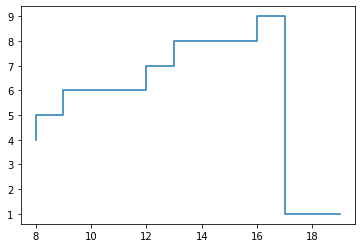

In [15]:
plt.step(range(8,20),hours_prompt['Ilość klientów'])

In [16]:
hours_prompt['Natężenie'] = [hours_prompt['Ilość klientów'][i]/sum(hours_prompt['Ilość klientów']) for i in range(len(hours_prompt['Godzina']))]

In [17]:
sum(hours_prompt['Natężenie'])

0.9999999999999999

## Gry

In [18]:
id_generator = lambda n: [*range(1, n+1)]

In [19]:
prompt_games[1:] = prompt_games[1:].sample(frac = 1)

In [20]:
prompt_games.head()

,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników
0,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN
1,5 sekund,inna,familijna,Lubisz adrenalinę? Polubisz 5 sekund! Kultowa ...,NIE,63.41,NaN,NaN
2,Pędzące Żółwie,planszowa,familijna,Celem gry “Pędzące żółwie” jest doprowadzenie ...,NIE,48.74,NaN,NaN
3,Jungle Speed Eco,inna,towarzyska,"Odkrywaj symbole, patrz uważnie i jak najszybc...",TAK,60.90,NaN,10.0
4,Scythe,planszowa,strategiczna,Scythe to gra idealnie łącząca ze sobą mechani...,TAK,289.00,NaN,5.0


In [21]:
wagi = expon.pdf(x=np.linspace(0,2,len(prompt_games['Nazwa'])),loc=-1/9)
prompt_games['wagi'] = [wagi[i]/np.sum(wagi) for i in range(len(wagi))]

In [22]:
prompt_games.reindex(labels=['game_id','Nazwa', 'rodzaj', 'kategoria', 'opis', 'Turniej', 'Kupno', 'Wypożyczenie', 'Liczba uczestników', 'wagi'], axis=1)
game_id = [*id_generator(len(prompt_games['Nazwa']))]
prompt_games.insert(0, 'game_id', game_id)

In [23]:
prompt_games.head()

,game_id,Nazwa,rodzaj,kategoria,opis,Turniej,Kupno,Wypożyczenie,Liczba uczestników,wagi
0,1,Jamniki,planszowa,familijna,"Podczas gry Twój jamnik będzie rósł, musisz wi...",NIE,59.99,NaN,NaN,0.045967
1,2,5 sekund,inna,familijna,Lubisz adrenalinę? Polubisz 5 sekund! Kultowa ...,NIE,63.41,NaN,NaN,0.044128
2,3,Pędzące Żółwie,planszowa,familijna,Celem gry “Pędzące żółwie” jest doprowadzenie ...,NIE,48.74,NaN,NaN,0.042363
3,4,Jungle Speed Eco,inna,towarzyska,"Odkrywaj symbole, patrz uważnie i jak najszybc...",TAK,60.90,NaN,10.0,0.040669
4,5,Scythe,planszowa,strategiczna,Scythe to gra idealnie łącząca ze sobą mechani...,TAK,289.00,NaN,5.0,0.039043


_______________

# Faza 2 - tabele pomocnicze

## Pracownicy

In [24]:
gender_generator = lambda n: random.choices(['M', 'F'], weights=[0.5, 0.5], k=n) 


def phone_generator(n=6):
    WST = [45, 50, 51, 53, 57, 60, 66, 69, 72, 73, 78, 79, 88]
    digit = [i for i in range(10)]
    phone_numbers = []
    while n > 0:
        phone = ''.join(map(str, [random.choice(WST), *random.choices(digit, k=7)]))
        if phone not in phone_numbers:
            phone_numbers.append(phone)
            n -= 1
        else:
            pass
    return phone_numbers


def first_name_generator(df):
    gender_list = df['gender']
    names = []
    for gender in gender_list:
        if gender == 'M':
            names.append(*random.choices(prompt_first_names_males['imię'], weights=prompt_first_names_males['prob']))
        elif gender == 'F':
            names.append(*random.choices(prompt_first_names_females['imię'], weights=prompt_first_names_females['prob']))
    return names


def last_name_generator(df):
    gender_list = df['gender']
    last_names = []
    for gender in gender_list:
        if gender == 'M':
            last_names.append(*random.choices(prompt_last_names_males['nazwisko'], weights=prompt_last_names_males['prob']))
        elif gender == 'F':
            last_names.append(*random.choices(prompt_last_names_females['nazwisko'], weights=prompt_last_names_females['prob']))
    return last_names


def email_generator(df):
    name = df['first_name'].str.cat(df['last_name'], sep='.').apply(lambda x: unidecode_expect_ascii(x))
    while name.is_unique == False:
        name = name.apply(lambda x: x + str(random.choice(range(10))))
    df['email'] = name.apply(lambda x: '@'.join([x, random.choice(prompt_emails['Domena'])]))


def to_date_generator(n):
    dates = [np.nan for i in range(n)]
    dates[n-2] = Faker().date_between(shop_open_date + datetime.timedelta(days=90), today - datetime.timedelta(days=90))
    return dates


def from_date_generator(df):
    n = df.shape[0]
    end_date = df['to_date'].loc[df['to_date'].isnull() == False].values[0]
    dates = [shop_open_date for i in range(n)]
    dates[n-1] = end_date + datetime.timedelta(days=30)
    return dates


def staff_update_generator(df):
    n = df.shape[0]
    df_date = df[['to_date', 'from_date']]
    df['updated_at'] = df_date.max(axis=1, skipna=True, numeric_only = False).apply(lambda x: x + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60))))
    

def salary_generator(df):
    n = df.shape[0]
    df['current_salary'] = [round(3490 + expon.rvs(scale=100, loc=80), 2) for i in range(n)]
    df.loc[df['to_date'].isnull() == False, 'current_salary'] = np.nan


def is_manager(df):
    n = df.shape[0]
    df['is_manager'] = [False for i in range(n)]
    df.loc[df['current_salary'] == df['current_salary'].max(), 'is_manager'] = True

In [25]:
def staff_df_generator(n):
    staff = pd.DataFrame({
        'gender': [*gender_generator(n)],
        'phone': [*phone_generator(n)],
        'to_date': [*to_date_generator(n)]
    })
    staff['city'] = np.full((1, staff.shape[0]), 'Wrocław')[0]
    staff['from_date'] = from_date_generator(staff)
    staff['first_name'] = first_name_generator(staff)
    staff['last_name'] = last_name_generator(staff)
    email_generator(staff)
    salary_generator(staff)
    is_manager(staff)
    staff_update_generator(staff)
    staff.sort_values(by=['updated_at'], inplace=True)
    staff['staff_id'] = id_generator(n)
    staff = staff.reindex(labels=['staff_id','first_name', 'last_name', 'phone', 'email', 'city', 'current_salary', 'is_manager', 'gender', 'from_date', 'to_date', 'updated_at'], axis=1)
    return staff

In [26]:
staff = staff_df_generator(staff_number)
staff

,staff_id,first_name,last_name,phone,email,city,current_salary,is_manager,gender,from_date,to_date,updated_at
2,1,KATARZYNA,SKRYPNYK,455817152,KATARZYNA.SKRYPNYK@home.pl,Wrocław,3746.96,True,F,2021-06-01,NaN,2021-06-01 11:00:23
0,2,MAKSYMILIAN,WESOŁOWSKI,788479544,MAKSYMILIAN.WESOLOWSKI@outlook.com,Wrocław,3722.10,False,M,2021-06-01,NaN,2021-06-01 13:25:37
3,3,KRYSTYNA,ZIĘBA,536272375,KRYSTYNA.ZIEBA@yahoo.com,Wrocław,3639.18,False,F,2021-06-01,NaN,2021-06-01 14:13:40
1,4,KONRAD,SIEDLARZ,454255738,KONRAD.SIEDLARZ@tlenofon.pl,Wrocław,3623.18,False,M,2021-06-01,NaN,2021-06-01 15:25:27
4,5,BARBARA,CZEKAJ,506760935,BARBARA.CZEKAJ@yahoo.com,Wrocław,NaN,False,F,2021-06-01,2023-02-21,2023-02-21 18:48:33
5,6,TYMOTEUSZ,WASILUK,577657229,TYMOTEUSZ.WASILUK@yahoo.com,Wrocław,3690.54,False,M,2023-03-23,NaN,2023-03-23 12:25:44


## Godziny pracy

In [27]:
hours = range(8,20)
weekdays = ['Poniedziałek', 'Wtorek', 'Środa', 'Czwartek', 'Piątek', 'Sobota']
workers = staff.staff_id
w = []
h = []
for i in range(8,20):
    for j in weekdays:
        w.append(j)
        h.append(i)
wk = []
for i in h:
    if i < 14:
        wk.append((1,2))
    else:
        wk.append((3,4,6))
        
weekday_hour_worker = pd.DataFrame({
    'weekdays': w, 
    'hour': h, 
    'staff': wk
})

In [28]:
weekday_hour_worker

,weekdays,hour,staff
0,Poniedziałek,8,"(1, 2)"
1,Wtorek,8,"(1, 2)"
2,Środa,8,"(1, 2)"
3,Czwartek,8,"(1, 2)"
4,Piątek,8,"(1, 2)"
...,...,...,...
67,Wtorek,19,"(3, 4, 6)"
68,Środa,19,"(3, 4, 6)"
69,Czwartek,19,"(3, 4, 6)"
70,Piątek,19,"(3, 4, 6)"


## Związki

In [29]:
#losowanie wektora z rozkładu normalnego z warunkiem na wartość minimalną
def norm_with_condition_generator(n, loc, scale, condition):
    dates = norm.rvs(scale=scale, loc=loc, size=n)
    mask = dates > condition
    while mask.all()== False:
        dates = norm.rvs(scale=scale, loc=loc, size=n)
        mask = dates > condition
    return dates.round().astype(int)

In [30]:
N = int(np.ceil(staff_number*1.5))


def realtionships_df_generator(staff_df, n=N):
    staff_id = []
    staff_gender = []
    update = []
    staff_df = staff_df.loc[staff_df['current_salary'].isnull() == False]
    for i in range(n):
        employee = random.choices(staff_df.staff_id.values, weights=staff_df.current_salary.values)
        staff_id.append(*employee)
        staff_gender.append(*staff_df['gender'].loc[staff_df.staff_id == employee[0]].values)
        update.append(Faker().date_between_dates(pd.to_datetime(staff_df.from_date.loc[staff_df.staff_id == employee[0]].values[0]), today) + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60))))
    df = pd.DataFrame({
        'staff_id': staff_id,
        'staff_gender': staff_gender,
        'dates_number': norm_with_condition_generator(n, 5, 2, 0),
        'updated_at': update
    })
    df.sort_values(by=['updated_at'], inplace=True)
    df['relationship_id'] = id_generator(df.shape[0])
    df['partner_id'] = id_generator(df.shape[0])
    df = df.reindex(labels=['relationship_id', 'staff_id','staff_gender', 'partner_id', 'dates_number', 'updated_at'], axis=1)
    return df

In [31]:
relationships = realtionships_df_generator(staff)
relationships

,relationship_id,staff_id,staff_gender,partner_id,dates_number,updated_at
8,1,4,M,1,9,2021-07-26 09:32:24
7,2,3,F,2,5,2021-10-26 13:11:57
2,3,4,M,3,6,2022-09-30 11:41:12
5,4,6,M,4,5,2023-04-29 18:29:23
3,5,6,M,5,6,2023-05-03 15:42:43
0,6,3,F,6,8,2023-05-10 10:21:30
1,7,6,M,7,6,2023-05-17 12:12:20
4,8,2,M,8,8,2023-05-25 15:09:39
6,9,4,M,9,4,2023-06-01 10:08:27


## Partnerzy

In [32]:
def partners_df_generator(relationships_df):
    partner = relationships_df.partner_id
    staff_gender = relationships_df.staff_gender.values
    gender = []
    for el in staff_gender:
        if el == 'M':
            gender.append(random.choices(['M', 'F'], weights=[0.1, 0.9])[0])
        elif el == 'F':
            gender.append(random.choices(['M', 'F'], weights=[0.9, 0.1])[0])

    partners = pd.DataFrame({
        'partner_id': partner,
        'gender': gender,
        'updated_at': relationships_df.updated_at
    })
    partners['name'] = first_name_generator(partners)
    partners.sort_values(by=['updated_at'], inplace=True)
    partners = partners.reindex(labels=['partner_id', 'name', 'gender', 'updated_at'], axis=1)
    return partners

In [33]:
partners = partners_df_generator(relationships)
partners

,partner_id,name,gender,updated_at
8,1,ANTONINA,F,2021-07-26 09:32:24
7,2,MATEUSZ,M,2021-10-26 13:11:57
2,3,LUCYNA,F,2022-09-30 11:41:12
5,4,MARIOLA,F,2023-04-29 18:29:23
3,5,ROKSANA,F,2023-05-03 15:42:43
0,6,WERONIKA,F,2023-05-10 10:21:30
1,7,MARTA,F,2023-05-17 12:12:20
4,8,GRZEGORZ,M,2023-05-25 15:09:39
6,9,HELENA,F,2023-06-01 10:08:27


## Klienci - część A

In [34]:
customers = pd.DataFrame({'customer_id': id_generator(customers_number)})

## Koszty utrzymania

In [35]:
def expenses_dates_generator(day=5):
    base = pd.DataFrame(prompt_dates.loc[(prompt_dates['Data'].dt.day == day) | (prompt_dates['Data'].dt.day == day+1), 'Data'])
    base['flag'] = base['Data'].dt.to_period('M') 
    base.drop_duplicates(['flag'], keep='first', inplace=True)
    base = base.reset_index()
    return base['Data']

In [36]:
def rent_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'CZYNSZ ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': np.full((1, date_df.shape[0]), 3250)[0],
        'type': np.full((1, date_df.shape[0]), 'CZYNSZ')[0]
    })
    return df


def energy_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'ENERGIA ELEKTRYCZNA ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(150,4),2),100) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'MEDIA')[0]
    })
    return df

def water_generator():
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'WODA ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [max(round(norm.rvs(50,2),2),15) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'MEDIA')[0]
    })
    return df


def heat_generator():
    dates = []
    date_df = prompt_dates.loc[prompt_dates['Data'].dt.day == 5, 'Data']
    for j in range(2021,2024):
        for i in range(4,11):
            day = datetime.datetime(j,i,5)
            dates.append(day.strftime("%Y-%m-%d"))
    for i in dates:
        date_df = date_df.drop(date_df[date_df == i].index)
    title = date_df.dt.month_name(locale='pl_PL').apply(lambda x: 'OGRZEWANIE ' + str(x).upper())
    df = pd.DataFrame({
        'date': date_df,
        'title': title,
        'amount': [round(norm.rvs(100,4),2) for i in range(date_df.shape[0])],
        'type': np.full((1, date_df.shape[0]), 'MEDIA')[0]
    })
    return df


def salary_generator(staff_df):
    date_df = expenses_dates_generator(10)
    all_staff = pd.concat([staff_df[['first_name', 'last_name', 'current_salary']]]*date_df.shape[0], ignore_index=True)
    staff_name = staff_df['first_name'].str.cat(staff_df['last_name'], sep=' ')
    names = pd.concat([staff_name]*date_df.shape[0], ignore_index=True)
    dates = np.repeat(date_df, staff_name.shape[0])
    dates = dates.reset_index()['Data']
    title_first = dates.dt.month_name(locale='pl_PL').apply(lambda x: 'PENSJA ' + str(x).upper())
    title = title_first.str.cat(names, sep=' ')
    df = pd.DataFrame({
        'date': dates,
        'title': title,
        'amount': all_staff['current_salary'],
        'type': np.full((1, title.shape[0]), 'PENSJA')[0]
    })
    to_date = pd.to_datetime(staff_df['to_date'].loc[staff_df['to_date'].isnull() == False].values[0])
    df.loc[(df['amount'].isnull() == True) & (df['date'] < to_date), 'amount'] = round(3490 + expon.rvs(scale=100, loc=80), 2)
    df.dropna(inplace=True)
    return df


def maintenance_expenses_df_generator():
    df = pd.DataFrame({
        'date': [],
        'title': [],
        'amount': [],
        'type': [],
        'updated_at': []
    })
    df = pd.concat([df, rent_generator(), energy_generator(), water_generator(), heat_generator(), salary_generator(staff)])
    df['updated_at'] = df['date'].apply(lambda x: x + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60))))
    df.sort_values(by=['updated_at'], inplace=True)
    df['payment_id'] = id_generator(df.shape[0])
    df['invoice_id'] = id_generator(df.shape[0])
    df['spend_id'] = id_generator(df.shape[0])
    df = df.reindex(['spend_id', 'title', 'amount', 'type','date', 'payment_id', 'invoice_id', 'updated_at'], axis=1)
    return df

In [37]:
maintenance_expenses = maintenance_expenses_df_generator()
maintenance_expenses

,spend_id,title,amount,type,date,payment_id,invoice_id,updated_at
3,1,CZYNSZ CZERWIEC,3250.00,CZYNSZ,2021-06-05,1,1,2021-06-05 11:46:41
3,2,WODA CZERWIEC,49.34,MEDIA,2021-06-05,2,2,2021-06-05 11:50:28
3,3,ENERGIA ELEKTRYCZNA CZERWIEC,151.64,MEDIA,2021-06-05,3,3,2021-06-05 16:36:42
4,4,PENSJA CZERWIEC BARBARA CZEKAJ,3639.46,PENSJA,2021-06-10,4,4,2021-06-10 13:55:37
3,5,PENSJA CZERWIEC KONRAD SIEDLARZ,3623.18,PENSJA,2021-06-10,5,5,2021-06-10 15:14:10
...,...,...,...,...,...,...,...,...
149,209,PENSJA CZERWIEC TYMOTEUSZ WASILUK,3690.54,PENSJA,2023-06-10,209,209,2023-06-10 11:18:50
146,210,PENSJA CZERWIEC KRYSTYNA ZIĘBA,3639.18,PENSJA,2023-06-10,210,210,2023-06-10 12:50:50
145,211,PENSJA CZERWIEC MAKSYMILIAN WESOŁOWSKI,3722.10,PENSJA,2023-06-10,211,211,2023-06-10 14:10:14
144,212,PENSJA CZERWIEC KATARZYNA SKRYPNYK,3746.96,PENSJA,2023-06-10,212,212,2023-06-10 16:51:07


## Typy wydatków

In [38]:
def expense_types_df_generator(expense_df):
    df = pd.DataFrame({
        'expenses_type': expense_df['type'],
        'updated_at': expense_df['updated_at']
    })
    df.drop_duplicates(subset=['expenses_type'], keep='last', inplace=True)
    df.sort_values(by=['updated_at'], inplace=True)
    df['expenses_type_id'] = id_generator(df.shape[0])
    df = df.reindex(['expenses_type_id', 'expenses_type', 'updated_at'], axis=1)
    return df

In [39]:
expense_types = expense_types_df_generator(maintenance_expenses)
expense_types

,expenses_type_id,expenses_type,updated_at
612,1,CZYNSZ,2023-06-05 08:11:43
612,2,MEDIA,2023-06-05 15:37:11
147,3,PENSJA,2023-06-10 19:54:25


## Tytuły wydatków

In [40]:
def expense_titles_df_generator(expense_df, expense_types_df):
    df = pd.DataFrame({
        'title': expense_df['title'],
        'expenses_type': expense_df['type'],
        'updated_at': expense_df['updated_at']
    })
    df.drop_duplicates(subset=['title'], keep='last', inplace=True)
    df = pd.merge(df, expense_types_df[['expenses_type_id', 'expenses_type']], how='left', on=['expenses_type'])
    df.sort_values(by=['updated_at'], inplace=True)
    df['title_id'] = id_generator(df.shape[0])
    df = df.reindex(['title_id', 'title', 'expenses_type_id', 'updated_at'], axis=1)
    return df

In [41]:
expense_titles = expense_titles_df_generator(maintenance_expenses, expense_types)
expense_titles.head()

,title_id,title,expenses_type_id,updated_at
0,1,OGRZEWANIE LUTY,2,2022-02-05 12:15:42
1,2,ENERGIA ELEKTRYCZNA LUTY,2,2022-02-05 13:28:28
2,3,CZYNSZ LUTY,1,2022-02-05 15:21:39
3,4,WODA LUTY,2,2022-02-05 19:35:52
4,5,CZYNSZ MARZEC,1,2022-03-05 11:29:57


## Wydatki i tytuły jeszcze raz

In [42]:
maintenance_expenses2 = pd.merge(maintenance_expenses, expense_titles[['title_id', 'title']], how='left', on='title')
maintenance_expenses2.sort_values(by=['updated_at'], inplace=True)
maintenance_expenses2 = maintenance_expenses2.reindex(['spend_id', 'title_id', 'type', 'amount','payment_id', 'invoice_id', 'updated_at'], axis=1)

In [43]:
maintenance_expenses2.head()

,spend_id,title_id,type,amount,payment_id,invoice_id,updated_at
0,1,106,CZYNSZ,3250.00,1,1,2021-06-05 11:46:41
1,2,107,MEDIA,49.34,2,2,2021-06-05 11:50:28
2,3,108,MEDIA,151.64,3,3,2021-06-05 16:36:42
3,4,12,PENSJA,3639.46,4,4,2021-06-10 13:55:37
4,5,113,PENSJA,3623.18,5,5,2021-06-10 15:14:10


## Turnieje

In [44]:
def game_tournament_generator():
    games = prompt_games.loc[prompt_games['Turniej'] == 'TAK', ['Nazwa', 'rodzaj', 'kategoria']]
    tournament_games = pd.merge(games, prompt_tournaments, left_on=['rodzaj', 'kategoria'], right_on=['Rodzaj', 'Kategoria'], suffixes=['_gry', '_turnieju'])
    tournament_games = tournament_games[['Nazwa_gry', 'Nazwa_turnieju']]
    return tournament_games


def tournament_staff_generator():
    staff = weekday_hour_worker.loc[(weekday_hour_worker['weekdays'] == 'Piątek') & (weekday_hour_worker['hour'] >= 15)]['staff'].sample(1, replace=True)
    return random.choice(staff.values[0])


def count_matches(x):
    suma = 0
    while x >= 0:
        suma += 2**x
        x -= 1
    return suma


In [45]:
def tournaments_df_generator():
    dates = pd.DataFrame(prompt_dates.loc[prompt_dates['Dzień tygodnia'] == 'Piątek', 'Data'].iloc[::6]).reset_index()['Data']
    n = dates.shape[0]
    tournament = game_tournament_generator()
    tournament = tournament.sample(n, replace=False, ignore_index=True) #nie może być ten sam wiersz
    tree_levels_number = randint.rvs(2, 4, size=n)
    matches = map(lambda x: count_matches(x), tree_levels_number)
    df = pd.DataFrame({
        'name': tournament['Nazwa_turnieju'],
        'game': tournament['Nazwa_gry'],
        'start_time': dates + datetime.timedelta(hours=15),
        'matches': matches,
        'tree_levels': tree_levels_number,
        'fee': np.full((1, n), 50)[0],
        'sign_up_deadline': dates - datetime.timedelta(days=3) + datetime.timedelta(hours=20),
        'staff_id': [tournament_staff_generator() for i in range(n)],
        'expenses': map(lambda x: round(x, 2), gamma.rvs(a=1.5, loc=200, scale=20, size=n)),
        'updated_at': dates.apply(lambda x: x + datetime.timedelta(hours=15, minutes=random.randint(1,5), seconds=random.randint(1,59)))
    })
    df.sort_values(by=['updated_at'], inplace=True)
    df['tournament_id'] = id_generator(n)
    df = df.reindex(['tournament_id', 'name', 'game', 'start_time', 'matches', 'tree_levels', 'fee', 'sign_up_deadline', 'staff_id', 'expenses', 'updated_at'], axis=1)
    return df

In [46]:
tournaments = tournaments_df_generator()
tournaments.head()

,tournament_id,name,game,start_time,matches,tree_levels,fee,sign_up_deadline,staff_id,expenses,updated_at
0,1,Wrocławski Konwent Planszówkowy,Catan: Osadnicy z Catanu,2021-06-04 15:00:00,7,2,50,2021-06-01 20:00:00,6,247.65,2021-06-04 15:05:11
1,2,Wrocławski Festiwal Gier Planszowych,Monopoly Classic,2021-07-16 15:00:00,15,3,50,2021-07-13 20:00:00,6,223.52,2021-07-16 15:04:33
2,3,Rewolucja Planszowych Geniuszy,Mastermind,2021-08-27 15:00:00,15,3,50,2021-08-24 20:00:00,3,213.20,2021-08-27 15:04:11
3,4,Krucjata Karcianych Mistrzów,Munchkin,2021-10-08 15:00:00,15,3,50,2021-10-05 20:00:00,3,206.67,2021-10-08 15:05:36
4,5,Wrocławski Konwent Planszówkowy,Terraformacja Marsa,2021-11-19 15:00:00,7,2,50,2021-11-16 20:00:00,6,249.38,2021-11-19 15:05:57


## Udziały

In [47]:
def sign_up_date_generator(deadline):
    date = prompt_dates['Data'].loc[(prompt_dates['Data'] < deadline) & (prompt_dates['Data'] > deadline - datetime.timedelta(days=14))].sample(1, ignore_index=True).values
    date = date[0] + pd.DateOffset(hours=random.choice(range(8,20)), minutes=random.choice(range(0,60)), seconds=random.choice(range(0,60)))
    return date

In [48]:
def participations_df_generator(tournament_df, customers_df):
    #liczba uczestników
    players = pd.merge(tournament_df[['game', 'tree_levels', 'tournament_id', 'fee', 'sign_up_deadline']], prompt_games[['Nazwa', 'Liczba uczestników']], left_on=['game'], right_on=['Nazwa'], how='left')
    players['Liczba uczestników'] = players['Liczba uczestników'].astype('int')
    players_number = players['Liczba uczestników'] * (2**players['tree_levels'])
    players['players'] = players_number

    #customer_id i miejsce
    participants = map(lambda x: customers_df['customer_id'].sample(x, replace=False, ignore_index=True).values, players_number)
    players['place'] = players['players'].apply(lambda x: [*range(1, x+1)])
    players['customer_id'] = list(participants)

    #ostateczny df
    df = players[['tournament_id', 'customer_id', 'fee', 'sign_up_deadline', 'place']]
    df = df.explode(['customer_id', 'place'], ignore_index=True)
    df['sign_up_date'] = df['sign_up_deadline'].apply(lambda x: sign_up_date_generator(x))
    df['updated_at'] = df['sign_up_date'].copy()
    df.sort_values(by=['updated_at'], inplace=True)
    df['particip_id'] = id_generator(df.shape[0])
    df = df.reindex(['particip_id', 'tournament_id', 'customer_id', 'place', 'sign_up_date', 'fee', 'updated_at'], axis=1)
    return df

In [49]:
participations = participations_df_generator(tournaments, customers)
participations.head()

,particip_id,tournament_id,customer_id,place,sign_up_date,fee,updated_at
8,1,1,399,9,2021-06-01 10:40:38,50,2021-06-01 10:40:38
11,2,1,1200,12,2021-06-01 10:42:07,50,2021-06-01 10:42:07
6,3,1,842,7,2021-06-01 10:50:35,50,2021-06-01 10:50:35
3,4,1,1378,4,2021-06-01 12:06:26,50,2021-06-01 12:06:26
13,5,1,256,14,2021-06-01 13:53:50,50,2021-06-01 13:53:50


## Magazyn

In [50]:
def get_value_from_another_column(df, search_column, search_value, target_column):
    matching_rows = df.loc[df[search_column] == search_value]
    target_value = matching_rows[target_column].values[0]
    return target_value


def sell(): 
    N = sum(prompt_dates['volume_sales'])*expon.rvs(loc=1/4)
    while N < 2500 or N > 3700: 
        N = sum(prompt_dates['volume_sales'])*expon.rvs(loc=1/4)
    ilość = list(map(round,prompt_games['wagi']*N))
    M = [prompt_games['Nazwa'][i:i+5] for i in range(0, len(prompt_games['Nazwa']), 5)]
    daty = []
    datysklepowe = list(prompt_dates['Data'].dt.strftime('%Y-%m-%d'))
    ilość2 = [sum(ilość[i:i+5]) for i in range(0,51,5)]
    for i in range(len(M)):
        d = max(len(M) + round(norm.rvs(0,5)),1)
        day = datetime.datetime(random.choice(range(2021,2024)),random.choice(range(1,13)),d).strftime("%Y-%m-%d")
        while day not in datysklepowe:
            day = datetime.datetime(random.choice(range(2021, 2024)), random.choice(range(1, 13)), d).strftime("%Y-%m-%d")
        daty.append(day)
    index = [x for x, y in zip(range(1,len(M)+1), ilość2) for _ in range(y)]
    indexy = [x for x, y in zip(index, ilość2) for _ in range(y)]
    daty_dost = [x for x, y in zip(daty, ilość2) for _ in range(y)]
    game = [x for x, y in zip(prompt_games['Nazwa'], ilość) for _ in range(y)]
    upd = [datetime.datetime.strptime(i, '%Y-%m-%d').replace(hour=random.randint(8, 19), minute=random.randint(0, 59), second=random.randint(0, 59)) for i in daty_dost]
    ceny = [x for x, y in zip(prompt_games['Kupno'], ilość2) for _ in range(y)]
    df = pd.DataFrame({
        'game': game,
        'destination': ['S' for _ in range(len(indexy))],
        'price': ceny,
        'active': ['True' for i in range(len(upd))],
        'purchase_payment': [0.8*cena for cena in ceny],
        'delivery_date': upd,
        'updated_at': upd
    }) 
    return df


def rental():
    N = 70
    games_r = [random.choice(prompt_games['Nazwa']) for i in range(N)]
    daty = ['2023-06-01' for _ in range(N)]
    daty_upd = [datetime.datetime.strptime(i, '%Y-%m-%d').replace(hour=random.randint(8, 19), minute=random.randint(0, 59), second=random.randint(0, 59)) for i in daty]
    df = pd.DataFrame({
        'game': games_r,
        'destination': ['R' for _ in range(N)],
        'price': [round(0.1*get_value_from_another_column(prompt_games,'Nazwa',gra,'Kupno'),2) for gra in games_r],
        'active': ['True' for i in range(N)],
        'purchase_payment': [round(0.8*get_value_from_another_column(prompt_games,'Nazwa',gra,'Kupno'),2) for gra in games_r],
        'delivery_date': daty_upd,
        'updated_at': daty_upd
    }) 
    return df


def games_for_tournament(tournaments_df):
    games_amount = tournaments_df[['game', 'tree_levels']].groupby('game').max().apply(lambda x: 2**x)
    games = pd.merge(games_amount, prompt_games, left_on=['game'], right_on=['Nazwa'])[['tree_levels', 'Nazwa', 'Kupno']]
    n = games.shape[0]
    dates = ['2023-06-01' for _ in range(n)]
    updated = [datetime.datetime.strptime(i, '%Y-%m-%d').replace(hour=random.randint(8, 19), minute=random.randint(0, 59), second=random.randint(0, 59)) for i in dates]
    df = pd.DataFrame({
        'game': games['Nazwa'],
        'destination': ['T' for _ in range(n)],
        'price': [np.nan for i in range(n)],
        'active': ['True' for i in range(n)],
        'purchase_payment': games['Kupno'],
        'delivery_date': updated,
        'updated_at': updated
    })
    return df


def inventory_df_generator(tournaments_df):
    sell_df = sell()
    rental_df = rental()
    tournament_df = games_for_tournament(tournaments_df)
    df = pd.concat([sell_df, rental_df, tournament_df])
    df.sort_values(by=['updated_at'], inplace=True)
    df['inventory_id'] = id_generator(df.shape[0])
    df = df.reindex(['inventory_id', 'game', 'destination', 'price', 'active', 'purchase_payment', 'delivery_date', 'updated_at'], axis=1)
    return df

In [51]:
inventory = inventory_df_generator(tournaments)
inventory.head(150)

,inventory_id,game,destination,price,active,purchase_payment,delivery_date,updated_at
1450,1,Odjechane Jednorożce,S,60.9,True,48.72,2021-10-18 08:05:58,2021-10-18 08:05:58
1677,2,UNO,S,60.9,True,48.72,2021-10-18 08:06:55,2021-10-18 08:06:55
1490,3,Odjechane Jednorożce,S,60.9,True,48.72,2021-10-18 08:07:25,2021-10-18 08:07:25
1552,4,Ryzyk Fizyk,S,60.9,True,48.72,2021-10-18 08:07:55,2021-10-18 08:07:55
1669,5,UNO,S,60.9,True,48.72,2021-10-18 08:10:14,2021-10-18 08:10:14
...,...,...,...,...,...,...,...,...
1608,146,Catan: Osadnicy z Catanu,S,60.9,True,48.72,2021-10-18 13:37:19,2021-10-18 13:37:19
1469,147,Odjechane Jednorożce,S,60.9,True,48.72,2021-10-18 13:37:25,2021-10-18 13:37:25
1562,148,Ryzyk Fizyk,S,60.9,True,48.72,2021-10-18 13:38:42,2021-10-18 13:38:42
1548,149,Ryzyk Fizyk,S,60.9,True,48.72,2021-10-18 13:40:46,2021-10-18 13:40:46


## Ceny gier

## Sprzedaże

## Rentale

## Gry

## Katrgorie gier i typy gier

## Klienci - część B

## Miasta

## Payments i invoices

------

# Faza 3 - ostateczne tabele